In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization, Conv1D, MaxPooling1D, Bidirectional, Layer
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.preprocessing import RobustScaler, LabelEncoder
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import TimeSeriesSplit
import matplotlib.pyplot as plt
from datetime import datetime
import joblib
import warnings
warnings.filterwarnings('ignore')
from tensorflow.keras import backend as K

#Set seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

In [2]:
# Load and preprocess data with timestamp fixing
print("📥 Loading data...")
df = pd.read_csv('wt84_with_alarms.csv', parse_dates=['date_time'])
df = df.sort_values('date_time')

print(f"🔄 Initial shape: {df.shape}")

# Step 1: remove duplicates
dupes = df[df['date_time'].duplicated()]
print(f"🧯 Duplicate timestamps found: {len(dupes)}")
df = df.drop_duplicates(subset='date_time', keep='last')
print("Dups dropped!")




📥 Loading data...
🔄 Initial shape: (210698, 319)
🧯 Duplicate timestamps found: 24
Dups dropped!


In [3]:
df['date_time'] = pd.to_datetime(df['date_time'])
df = df.sort_values('date_time')  # ensure it's sorted

# Find time differences between rows
diffs = df['date_time'].diff().dropna()

# Check if all differences are exactly 5 minutes
is_5min = (diffs == pd.Timedelta(minutes=5)).all()
print("✅ Is data in consistent 5-min intervals?", is_5min)


✅ Is data in consistent 5-min intervals? False


In [4]:
# Step 2: Create full 5-min index
print("📆 Reindexing to fill missing timestamps...")
full_range = pd.date_range(start=df['date_time'].min(), end=df['date_time'].max(), freq='5min')

# Step 3: Reindex
df = df.set_index('date_time')
df = df.reindex(full_range)

# Step 4: Rename and reset index
df = df.reset_index().rename(columns={'index': 'date_time'})

# Step 5: Fill missing rows using forward and backward fill
df = df.fillna(method='ffill').fillna(method='bfill')

print(f"✅ Shape after filling missing intervals: {df.shape}")

📆 Reindexing to fill missing timestamps...
✅ Shape after filling missing intervals: (308800, 319)


In [5]:

def alarm_feature_engineering(df, alarm_col='alarm_system', time_col='date_time'):
    """
    Create alarm-related features and handle missing values.
    """
    df = df.copy()
    
    # Calculate hours since last alarm
    next_alarms = df[df[alarm_col] == 1][time_col].reset_index(drop=True)
    
    def compute_hours_since_last_alarm(current_time):
        past_alarms = next_alarms[next_alarms < current_time]
        return (current_time - past_alarms.iloc[-1]).total_seconds() / 3600 if not past_alarms.empty else np.nan
    
    df['hours_since_last_alarm'] = df[time_col].apply(compute_hours_since_last_alarm)
    df['recent_alarm_flag'] = (df['hours_since_last_alarm'] < 6).astype(int)
    df['alarm_frequency_24h'] = df[alarm_col].rolling(window=48).sum()
    
    # Fill missing values
    df['hours_since_last_alarm'] = df['hours_since_last_alarm'].fillna(48)  # Max hours
    df['alarm_frequency_24h'] = df['alarm_frequency_24h'].fillna(0)
    
    # Alarm lags
    df['alarm_system_lag_0.5h'] = df[alarm_col].shift(1)
    df['alarm_system_lag_2h'] = df[alarm_col].shift(4)
    
    return df

def enhanced_feature_engineering(df, target_col='wtrm_avg_TrmTmp_Gbx', time_col='date_time'):
    """
    Create enhanced features and handle missing values.
    """
    df = df.copy()
    
    # Critical sensors with extended lags
    critical_temp_sensors = [
        'wtrm_avg_TrmTmp_GbxBrg452', 'wtrm_avg_TrmTmp_GbxBrg151', 'wtrm_avg_TrmTmp_Gbx'
    ]
    lag_steps = [1, 2, 4, 8, 16]  # 0.5h, 1h, 2h, 4h, 8h
    
    for sensor in critical_temp_sensors:
        if sensor in df.columns:
            for lag in lag_steps:
                df[f'{sensor}_lag_{lag*0.5}h'] = df[sensor].shift(lag)
            df[f'{sensor}_delta_1h'] = df[sensor] - df[sensor].shift(2)
            df[f'{sensor}_delta_4h'] = df[sensor] - df[sensor].shift(8)

    df['wtrm_avg_TrmTmp_Gbx_rolling_mean_3.0h'] = df['wtrm_avg_TrmTmp_Gbx'].rolling(window=6).mean()
    
    # Operational features
    essential_ops = ['wgen_avg_Spd', 'wgdc_avg_TriGri_PwrAt', 'wtrm_avg_Gbx_OilPres']
    for col in essential_ops:
        if col in df.columns:
            df[f'{col}_delta_1h'] = df[col] - df[col].shift(2)
            df[f'{col}_rolling_mean_6h'] = df[col].rolling(window=12).mean()
    
    # Time features
    df['hour'] = df[time_col].dt.hour + df[time_col].dt.minute / 60
    df['hour_sin'] = np.sin(2 * np.pi * df['hour'] / 24)
    df['hour_cos'] = np.cos(2 * np.pi * df['hour'] / 24)
    df['day_of_week'] = df[time_col].dt.dayofweek
    
    # NEW: Add seasonal feature (week of year)
    df['week_of_year'] = df[time_col].dt.isocalendar().week.astype(int)
    df['week_sin'] = np.sin(2 * np.pi * df['week_of_year'] / 52)
    df['week_cos'] = np.cos(2 * np.pi * df['week_of_year'] / 52)

    df['month'] = df[time_col].dt.month
    df['month_sin'] = np.sin(2 * np.pi * df['month'] / 12)
    df['month_cos'] = np.cos(2 * np.pi * df['month'] / 12)


    # Handle missing values
    df = df.fillna(method='ffill').fillna(method='bfill')
    df = df.dropna().reset_index(drop=True)
    
    return df

def check_columns_and_missing_values(df, common_features, dataset_name="Dataset"):
    """
    Check available columns and missing values.
    """
    print(f"\n🔍 Checking columns and missing values in {dataset_name}...")
    
    # Check available features
    common_features = [f for f in common_features if f in df.columns]
    missing_features = [f for f in common_features if f not in df.columns]
    
    print(f"✅ Available features ({len(common_features)}): {common_features}")
    if missing_features:
        print(f"⚠️ Missing features ({len(missing_features)}): {missing_features}")
    
    # Check missing values
    missing_counts = df.isnull().sum()
    missing_percentage = (missing_counts / len(df)) * 100
    missing_df = pd.DataFrame({
        'MissingCount': missing_counts,
        'MissingPercentage (%)': missing_percentage
    })
    missing_df = missing_df[missing_df.MissingCount > 0].sort_values(by='MissingCount', ascending=False)
    
    if not missing_df.empty:
        print(f"⚠️ Columns with missing values in {dataset_name}:")
        print(missing_df)
    else:
        print(f"✅ No missing values found in {dataset_name}.")
    
    return common_features

In [6]:
print("\n🔍 Checking for non-numeric columns in the dataset...")
non_numeric_cols = df.select_dtypes(exclude=[np.number]).columns.tolist()
print(f"Found {len(non_numeric_cols)} non-numeric columns:")
print(non_numeric_cols)


🔍 Checking for non-numeric columns in the dataset...
Found 4 non-numeric columns:
['date_time', 'alarm_desc', 'date_time_end', 'alarm_system']


In [7]:
df = df.dropna(subset=['alarm_desc'])
print(f"✅ Dropped rows with missing 'alarm_desc'. New shape: {df.shape}")

✅ Dropped rows with missing 'alarm_desc'. New shape: (308800, 319)


In [8]:
# Encode non-numeric columns
if 'alarm_system' in df.columns:
    le = LabelEncoder()
    df['alarm_system'] = le.fit_transform(df['alarm_system'].astype(str))
    joblib.dump(le, 'label_encoder_alarm_system.pkl')

In [9]:
# Aggregate to 15-minute intervals
print("🔄 Aggregating data from 5-minute to 15-minute intervals...")
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
df_numeric = df[['date_time'] + numeric_cols].set_index('date_time').resample('15min').mean()
if 'alarm_system' in df.columns:
    alarm_30min = df[['date_time', 'alarm_system']].set_index('date_time').resample('15min').max()
    df_numeric['alarm_system'] = alarm_30min['alarm_system']
df_30min = df_numeric.reset_index()

🔄 Aggregating data from 5-minute to 15-minute intervals...


In [10]:
percentile_95 = df_30min['wtrm_avg_TrmTmp_Gbx'].quantile(0.85)
print(f"85th percentile of wtrm_avg_TrmTmp_Gbx: {percentile_95:.2f}")


85th percentile of wtrm_avg_TrmTmp_Gbx: 70.00


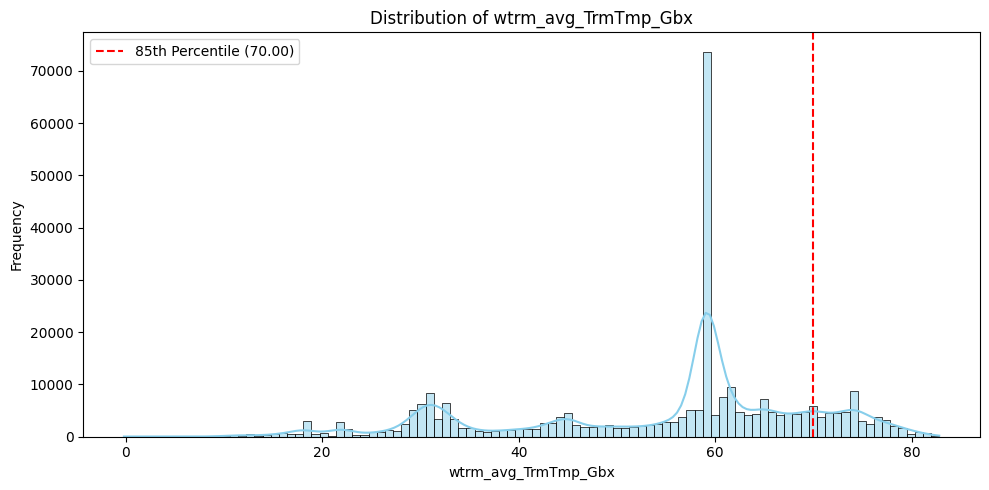

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns

# Calculate 95th percentile
percentile_95 = df_30min['wtrm_avg_TrmTmp_Gbx'].quantile(0.85)

# Plot distribution
plt.figure(figsize=(10, 5))
sns.histplot(df['wtrm_avg_TrmTmp_Gbx'], bins=100, kde=True, color='skyblue')

# Add vertical line at 95th percentile
plt.axvline(percentile_95, color='red', linestyle='--', label=f'85th Percentile ({percentile_95:.2f})')

# Labels and legend
plt.title('Distribution of wtrm_avg_TrmTmp_Gbx')
plt.xlabel('wtrm_avg_TrmTmp_Gbx')
plt.ylabel('Frequency')
plt.legend()
plt.tight_layout()
plt.show()


In [12]:
df_30min.head()

,date_time,turbine_id,wgdc_avg_TriGri_PhV_phsA,wgdc_avg_TriGri_PhV_phsB,wgdc_avg_TriGri_PhV_phsC,wgdc_avg_TriGri_PhV,wgdc_avg_TriGri_A_phsA,wgdc_avg_TriGri_A_phsB,wgdc_avg_TriGri_A_phsC,wgdc_avg_TriGri_A,...,wmet_max_MetAlt1_Press,wmet_min_MetAlt1_Hum,wmet_min_DewPTmp,wmet_min_MetAlt1_Press,wmet_sdv_MetAlt1_Hum,wmet_sdv_DewPTmp,wmet_sdv_MetAlt1_Press,alarm_id,availability,alarm_system
0,2012-01-01 01:00:00,84.0,392.476500,390.478500,392.816000,391.489000,393.014000,361.928000,379.043500,377.982000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5132.0,1.0,7
1,2012-01-01 01:15:00,84.0,393.879667,391.867667,393.889333,392.883000,573.900000,538.256667,555.398000,555.822667,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5132.0,1.0,7
2,2012-01-01 01:30:00,84.0,396.111333,394.133000,396.106000,395.118333,1007.589333,965.244333,982.080333,984.974333,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5132.0,1.0,7
3,2012-01-01 01:45:00,84.0,397.367667,395.719333,397.298333,396.387333,1262.640000,1218.763333,1234.256667,1238.533333,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5132.0,1.0,7
4,2012-01-01 02:00:00,84.0,397.111333,395.548667,397.380333,396.379333,1221.010000,1177.076667,1192.993333,1197.030000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5132.0,1.0,7


In [13]:
df_30min.shape


(102934, 317)

In [14]:
print("\n📊 Missing values after cleaning and aggregation:")
print(df_30min.isnull().sum().sort_values(ascending=False).head(10))



📊 Missing values after cleaning and aggregation:
alarm_system                0
date_time                   0
turbine_id                  0
wgdc_avg_TriGri_PhV_phsA    0
wgdc_avg_TriGri_PhV_phsB    0
wgdc_avg_TriGri_PhV_phsC    0
wgdc_avg_TriGri_PhV         0
wgdc_avg_TriGri_A_phsA      0
wgdc_avg_TriGri_A_phsB      0
wgdc_avg_TriGri_A_phsC      0
dtype: int64


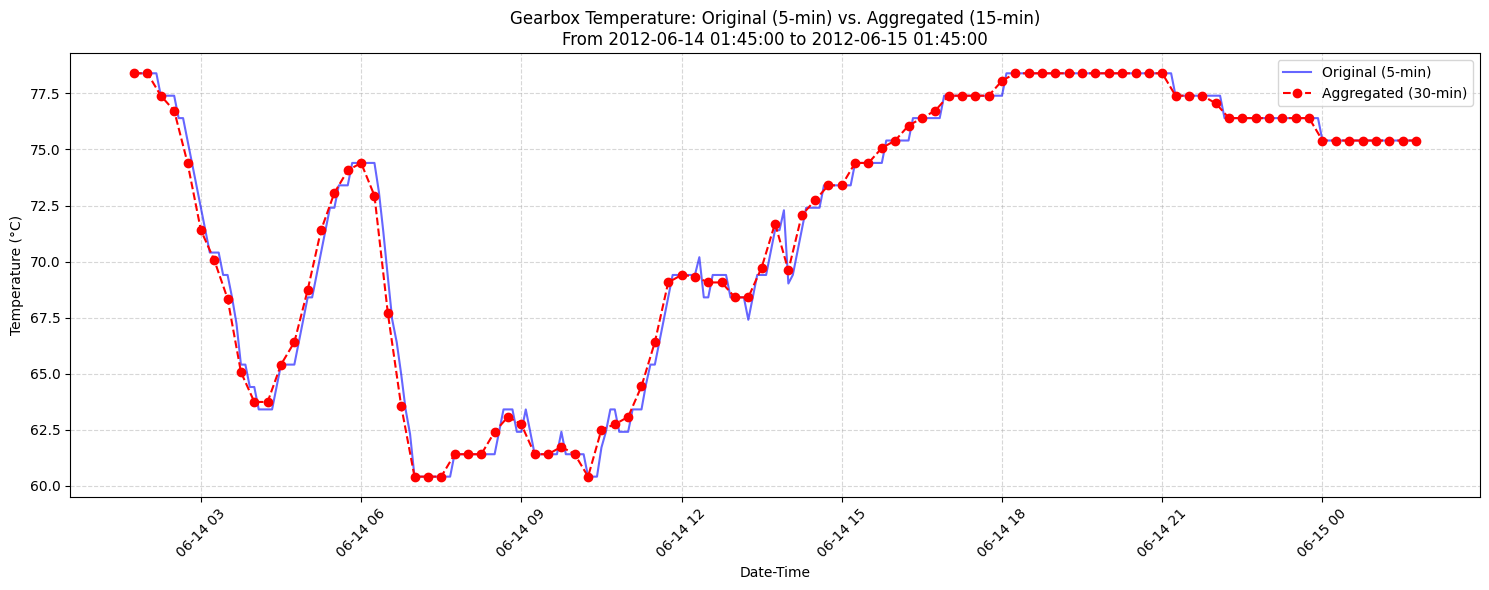

In [15]:


# Select a random 24-hour window for plotting
# Avoid edges to ensure valid data
valid_indices = df_30min['date_time'].iloc[48:-48].reset_index(drop=True)  # Skip first/last 24 hours
random_index = np.random.choice(valid_indices.index)
start_time = valid_indices[random_index]
end_time = start_time + pd.Timedelta(hours=24)

# Extract windows for both datasets
df_raw_window = df[(df['date_time'] >= start_time) & (df['date_time'] <= end_time)]
df_30min_window = df_30min[(df_30min['date_time'] >= start_time) & (df_30min['date_time'] <= end_time)]

# Create the plot
plt.figure(figsize=(15, 6))
plt.plot(df_raw_window['date_time'], df_raw_window['wtrm_avg_TrmTmp_Gbx'], 
         label='Original (5-min)', color='blue', alpha=0.6, linewidth=1.5)
plt.plot(df_30min_window['date_time'], df_30min_window['wtrm_avg_TrmTmp_Gbx'], 
         label='Aggregated (30-min)', color='red', marker='o', linestyle='--', linewidth=1.5)

# Customize the plot
plt.title(f'Gearbox Temperature: Original (5-min) vs. Aggregated (15-min)\nFrom {start_time} to {end_time}', fontsize=12)
plt.xlabel('Date-Time', fontsize=10)
plt.ylabel('Temperature (°C)', fontsize=10)
plt.legend(fontsize=10)
plt.grid(True, linestyle='--', alpha=0.5)
plt.xticks(rotation=45)
plt.tight_layout()

# Display the plot
plt.show()

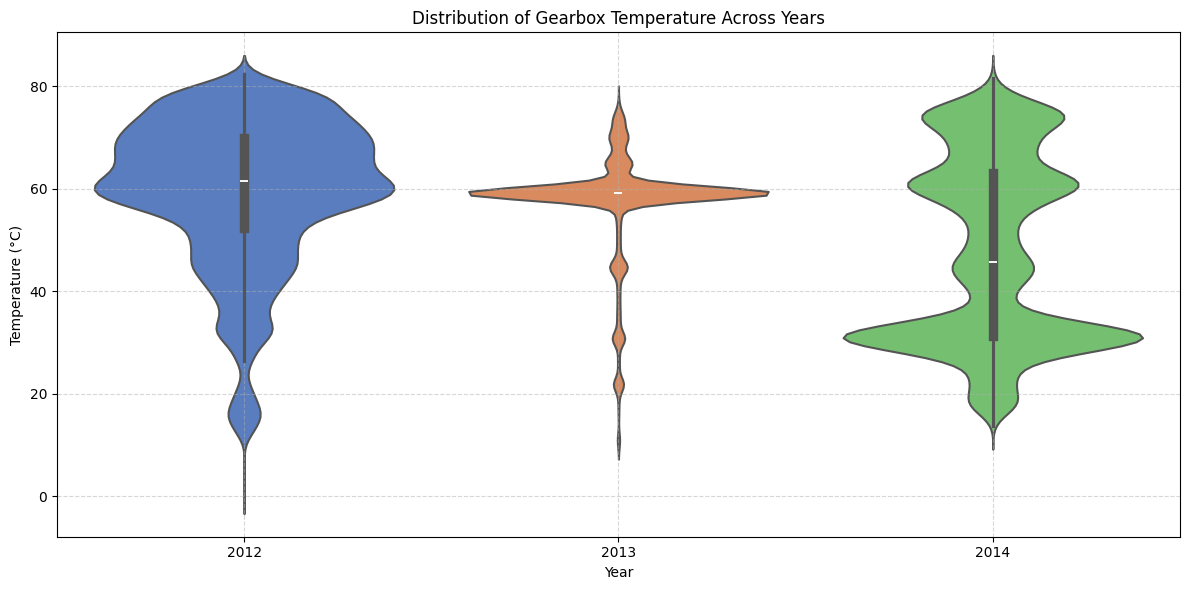

In [16]:

# Extract year from date_time
df_30min['year'] = df_30min['date_time'].dt.year

# Create the violin plot
plt.figure(figsize=(12, 6))
sns.violinplot(x='year', y='wtrm_avg_TrmTmp_Gbx', data=df_30min, inner='box', palette='muted', linewidth=1.5)

# Customize the plot
plt.title('Distribution of Gearbox Temperature Across Years', fontsize=12)
plt.xlabel('Year', fontsize=10)
plt.ylabel('Temperature (°C)', fontsize=10)
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()

# Display the plot
plt.show()

# Clean up temporary column
df_30min = df_30min.drop(columns=['year'])

In [17]:
# === Step: Split data ===
train_ratio, val_ratio = 0.7, 0.15
train_size = int(len(df_30min) * train_ratio)
val_size = int(len(df_30min) * val_ratio)

df_train = df_30min.iloc[:train_size].copy()
df_val = df_30min.iloc[train_size:train_size+val_size].copy()
df_test = df_30min.iloc[train_size+val_size:].copy()




In [18]:
# === Step: Feature engineering per split ===
print("⚙️ Applying feature engineering to train, validation, and test sets...")
df_train = alarm_feature_engineering(df_train)
df_train = enhanced_feature_engineering(df_train)
df_val = alarm_feature_engineering(df_val)
df_val = enhanced_feature_engineering(df_val)
df_test = alarm_feature_engineering(df_test)
df_test = enhanced_feature_engineering(df_test)

# Check for duplicate columns
duplicate_columns = df_train.columns[df_train.columns.duplicated()].tolist()
if duplicate_columns:
    print(f"⚠️ Duplicate columns in df_train: {duplicate_columns}")
else:
    print("✅ No duplicate columns in df_train.")

⚙️ Applying feature engineering to train, validation, and test sets...
✅ No duplicate columns in df_train.


In [19]:
# === Step: Define features and check ===
common_features = [
    'wtrm_avg_TrmTmp_GbxBrg452', 'wtrm_avg_TrmTmp_GbxBrg151', 'wtrm_avg_TrmTmp_Gbx',
    'wtrm_avg_Gbx_OilPres', 'wgen_avg_Spd', 'wgdc_avg_TriGri_PwrAt',
    'wtrm_avg_TrmTmp_Gbx_lag_0.5h', 'wtrm_avg_TrmTmp_Gbx_lag_1.0h', 'wtrm_avg_TrmTmp_Gbx_lag_2.0h',
    'wtrm_avg_TrmTmp_Gbx_lag_4.0h', 'wtrm_avg_TrmTmp_GbxBrg452_lag_0.5h', 'wtrm_avg_TrmTmp_GbxBrg151_lag_0.5h',
    'wtrm_avg_TrmTmp_Gbx_delta_1h', 'wgen_avg_Spd_delta_1h', 'wgdc_avg_TriGri_PwrAt_delta_1h',
    'alarm_system', 'recent_alarm_flag', 'alarm_frequency_24h',
    'hour_sin', 'hour_cos', 'day_of_week', 'wtrm_avg_TrmTmp_Gbx_rolling_mean_3.0h'
]

# Remove duplicates from common_features
# Remove target column from features
common_features = list(dict.fromkeys(common_features))
if 'wtrm_avg_TrmTmp_Gbx' in common_features:
    common_features.remove('wtrm_avg_TrmTmp_Gbx')

train_features = check_columns_and_missing_values(df_train, common_features, "Training")
val_features = check_columns_and_missing_values(df_val, common_features, "Validation")
test_features = check_columns_and_missing_values(df_test, common_features, "Test")

common_features = sorted(set(train_features) & set(val_features) & set(test_features))
print(f"\n✅ Common features across all splits ({len(common_features)}): {common_features}")

# Final clean splits
df_train_clean = df_train[common_features + ['wtrm_avg_TrmTmp_Gbx', 'date_time']].copy()
df_val_clean = df_val[common_features + ['wtrm_avg_TrmTmp_Gbx', 'date_time']].copy()
df_test_clean = df_test[common_features + ['wtrm_avg_TrmTmp_Gbx', 'date_time']].copy()

# Remove duplicate columns if any
for col in ['wtrm_avg_TrmTmp_Gbx', 'date_time']:
    if col in common_features:
        common_features.remove(col)

print(f"\n✅ Final dataset shapes:")
print(f"   Train: {df_train_clean.shape}")
print(f"   Validation: {df_val_clean.shape}")
print(f"   Test: {df_test_clean.shape}")


🔍 Checking columns and missing values in Training...
✅ Available features (21): ['wtrm_avg_TrmTmp_GbxBrg452', 'wtrm_avg_TrmTmp_GbxBrg151', 'wtrm_avg_Gbx_OilPres', 'wgen_avg_Spd', 'wgdc_avg_TriGri_PwrAt', 'wtrm_avg_TrmTmp_Gbx_lag_0.5h', 'wtrm_avg_TrmTmp_Gbx_lag_1.0h', 'wtrm_avg_TrmTmp_Gbx_lag_2.0h', 'wtrm_avg_TrmTmp_Gbx_lag_4.0h', 'wtrm_avg_TrmTmp_GbxBrg452_lag_0.5h', 'wtrm_avg_TrmTmp_GbxBrg151_lag_0.5h', 'wtrm_avg_TrmTmp_Gbx_delta_1h', 'wgen_avg_Spd_delta_1h', 'wgdc_avg_TriGri_PwrAt_delta_1h', 'alarm_system', 'recent_alarm_flag', 'alarm_frequency_24h', 'hour_sin', 'hour_cos', 'day_of_week', 'wtrm_avg_TrmTmp_Gbx_rolling_mean_3.0h']
✅ No missing values found in Training.

🔍 Checking columns and missing values in Validation...
✅ Available features (21): ['wtrm_avg_TrmTmp_GbxBrg452', 'wtrm_avg_TrmTmp_GbxBrg151', 'wtrm_avg_Gbx_OilPres', 'wgen_avg_Spd', 'wgdc_avg_TriGri_PwrAt', 'wtrm_avg_TrmTmp_Gbx_lag_0.5h', 'wtrm_avg_TrmTmp_Gbx_lag_1.0h', 'wtrm_avg_TrmTmp_Gbx_lag_2.0h', 'wtrm_avg_TrmTmp_G

In [20]:
import json

# === 💾 Export processed test data (much smaller) ===
print("💾 Exporting processed test data...")

# Export test data with features and target
df_test_export = df_test_clean[common_features + ['wtrm_avg_TrmTmp_Gbx', 'date_time']].copy()
df_test_export.to_csv("test_data_processed.csv", index=False)
print(f"✅ Exported test data: {df_test_export.shape} -> test_data_processed.csv")

# Save common features for Streamlit
with open('common_features.json', 'w') as f:
    json.dump(common_features, f)
print("✅ Saved common_features.json")

💾 Exporting processed test data...
✅ Exported test data: (15441, 23) -> test_data_processed.csv
✅ Saved common_features.json


In [21]:
df_test_export.head()

,alarm_frequency_24h,alarm_system,day_of_week,hour_cos,hour_sin,recent_alarm_flag,wgdc_avg_TriGri_PwrAt,wgdc_avg_TriGri_PwrAt_delta_1h,wgen_avg_Spd,wgen_avg_Spd_delta_1h,...,wtrm_avg_TrmTmp_GbxBrg452,wtrm_avg_TrmTmp_GbxBrg452_lag_0.5h,wtrm_avg_TrmTmp_Gbx_delta_1h,wtrm_avg_TrmTmp_Gbx_lag_0.5h,wtrm_avg_TrmTmp_Gbx_lag_1.0h,wtrm_avg_TrmTmp_Gbx_lag_2.0h,wtrm_avg_TrmTmp_Gbx_lag_4.0h,wtrm_avg_TrmTmp_Gbx_rolling_mean_3.0h,wtrm_avg_TrmTmp_Gbx,date_time
0,0.0,7,0,-0.896873,0.442289,0,-9.601720,1.509077,0.000556,-0.000176,...,29.9,29.9,0.000000,27.4,27.4,27.4,27.4,27.622222,27.400000,2014-06-30 10:15:00
1,0.0,7,0,-0.923880,0.382683,0,-8.586490,1.509077,0.000491,-0.000176,...,29.9,29.9,0.000000,27.4,27.4,27.4,27.4,27.622222,27.400000,2014-06-30 10:30:00
2,0.0,7,0,-0.946930,0.321439,0,-8.092643,1.509077,0.000380,-0.000176,...,29.9,29.9,0.000000,27.4,27.4,27.4,27.4,27.622222,27.400000,2014-06-30 10:45:00
3,0.0,7,0,-0.965926,0.258819,0,-6.083637,2.502853,0.000000,-0.000491,...,29.9,29.9,0.000000,27.4,27.4,27.4,27.4,27.622222,27.400000,2014-06-30 11:00:00
4,0.0,7,0,-0.980785,0.195090,0,-6.137283,1.955360,0.000062,-0.000318,...,29.9,29.9,0.333333,27.4,27.4,27.4,27.4,27.622222,27.733333,2014-06-30 11:15:00


In [22]:
# === Continue with training using generated sequences for train/val ===
def generate_sequences(df, feature_cols, target_col='wtrm_avg_TrmTmp_Gbx', lookback_steps=384, forecast_steps=192):
    X, y, indices = [], [], []
    feature_data = df[feature_cols].values
    target_data = df[target_col].values
    dates = df['date_time'].values
    
    for i in range(lookback_steps, len(df) - forecast_steps):
        X.append(feature_data[i - lookback_steps:i])
        y.append(target_data[i:i + forecast_steps])  
        indices.append(dates[i])
    
    return np.array(X), np.array(y), np.array(indices)

# Continue with model training...
print("📊 Generating sequences for training, validation, and testing...")
X_train, y_train, train_dates = generate_sequences(df_train_clean, common_features)
X_val, y_val, val_dates = generate_sequences(df_val_clean, common_features)
X_test, y_test, test_dates = generate_sequences(df_test_clean, common_features)

print(f"✅ X_train: {X_train.shape}, y_train: {y_train.shape}")
print(f"✅ X_val: {X_val.shape}, y_val: {y_val.shape}")
print(f"✅ X_test: {X_test.shape}, y_test: {y_test.shape}")

📊 Generating sequences for training, validation, and testing...
✅ X_train: (71477, 384, 21), y_train: (71477, 192)
✅ X_val: (14864, 384, 21), y_val: (14864, 192)
✅ X_test: (14865, 384, 21), y_test: (14865, 192)


In [23]:

print(f"✅ X_train: {X_train.shape}, y_train: {y_train.shape}")
print(f"✅ X_val: {X_val.shape}, y_val: {y_val.shape}")
print(f"✅ X_test: {X_test.shape}, y_test: {y_test.shape}")

# Verify feature count
if X_train.shape[2] != len(common_features):
    print("X_train.shape[2]:", X_train.shape[2])
    print("len(common_features):", len(common_features))
    print("common_features:", common_features)

    raise ValueError(f"X_train has {X_train.shape[2]} features, but common_features has {len(common_features)}")

# Scale features
print("🔄 Scaling with RobustScaler...")
feature_scaler = RobustScaler()
X_train_reshaped = X_train.reshape(-1, X_train.shape[-1])
feature_scaler.fit(X_train_reshaped)
feature_scaler.feature_names_in_ = np.array(common_features)
print("🧠 Features used by feature_scaler:")
print(feature_scaler.feature_names_in_.tolist())
print(f"Number of features in X_train_reshaped: {X_train_reshaped.shape[1]}")

X_train_scaled = feature_scaler.transform(X_train_reshaped).reshape(X_train.shape)
X_val_scaled = feature_scaler.transform(X_val.reshape(-1, X_val.shape[-1])).reshape(X_val.shape)
X_test_scaled = feature_scaler.transform(X_test.reshape(-1, X_test.shape[-1])).reshape(X_test.shape)
print("✅ Scaling completed")

✅ X_train: (71477, 384, 21), y_train: (71477, 192)
✅ X_val: (14864, 384, 21), y_val: (14864, 192)
✅ X_test: (14865, 384, 21), y_test: (14865, 192)
🔄 Scaling with RobustScaler...
🧠 Features used by feature_scaler:
['alarm_frequency_24h', 'alarm_system', 'day_of_week', 'hour_cos', 'hour_sin', 'recent_alarm_flag', 'wgdc_avg_TriGri_PwrAt', 'wgdc_avg_TriGri_PwrAt_delta_1h', 'wgen_avg_Spd', 'wgen_avg_Spd_delta_1h', 'wtrm_avg_Gbx_OilPres', 'wtrm_avg_TrmTmp_GbxBrg151', 'wtrm_avg_TrmTmp_GbxBrg151_lag_0.5h', 'wtrm_avg_TrmTmp_GbxBrg452', 'wtrm_avg_TrmTmp_GbxBrg452_lag_0.5h', 'wtrm_avg_TrmTmp_Gbx_delta_1h', 'wtrm_avg_TrmTmp_Gbx_lag_0.5h', 'wtrm_avg_TrmTmp_Gbx_lag_1.0h', 'wtrm_avg_TrmTmp_Gbx_lag_2.0h', 'wtrm_avg_TrmTmp_Gbx_lag_4.0h', 'wtrm_avg_TrmTmp_Gbx_rolling_mean_3.0h']
Number of features in X_train_reshaped: 21
✅ Scaling completed


In [24]:
# 🔄 Scale the target values (y_train, y_val, y_test)
print("🔄 Scaling target values with RobustScaler...")
target_scaler = RobustScaler()

# Reshape target to 2D for scaler (samples, forecast_steps)
y_train_reshaped = y_train.reshape(-1, y_train.shape[1])
y_val_reshaped = y_val.reshape(-1, y_val.shape[1])
y_test_reshaped = y_test.reshape(-1, y_test.shape[1])

# Fit scaler only on training targets
target_scaler.fit(y_train_reshaped)

# Transform
y_train_scaled = target_scaler.transform(y_train_reshaped)
y_val_scaled = target_scaler.transform(y_val_reshaped)
y_test_scaled = target_scaler.transform(y_test_reshaped)

print("✅ Target scaling completed")


🔄 Scaling target values with RobustScaler...
✅ Target scaling completed


In [25]:
print(f"Number of features in X_train_reshaped: {X_train_reshaped.shape[1]}")

Number of features in X_train_reshaped: 21


In [26]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv1D, MaxPooling1D, LSTM, Dense, Dropout, BatchNormalization, Bidirectional, LeakyReLU
from tensorflow.keras.layers import Attention, GlobalAveragePooling1D, Add
from tensorflow.keras.regularizers import l2

# def create_model_with_attention(input_shape, output_shape):
#     inputs = Input(shape=input_shape)

#     # Conv1D block
#     x = Conv1D(filters=64, kernel_size=3, padding='same', kernel_regularizer=l2(1e-4))(inputs)
#     x = BatchNormalization()(x)
#     x = LeakyReLU()(x)
#     x = MaxPooling1D(pool_size=2)(x)
#     x = Dropout(0.3)(x)

#     # BiLSTM (return sequences for attention)
#     x = Bidirectional(LSTM(64, return_sequences=True, dropout=0.3))(x)

#     # Attention Layer
#     attention_output = Attention()([x, x])  # Self-attention
#     x = Add()([x, attention_output])        # Residual connection
#     x = GlobalAveragePooling1D()(x)         # Reduce sequence to vector

#     # Dense block
#     x = Dense(64, kernel_regularizer=l2(1e-4))(x)
#     x = LeakyReLU()(x)
#     x = Dropout(0.3)(x)

#     outputs = Dense(output_shape, activation='linear')(x)

#     model = Model(inputs, outputs)
#     return model




# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import Conv1D, MaxPooling1D, LSTM, Dense, Dropout, BatchNormalization, Bidirectional, LeakyReLU
# from tensorflow.keras.optimizers import Adam
# from tensorflow.keras.losses import Huber
# from tensorflow.keras.regularizers import l2

def create_improved_model(input_shape, output_shape):
    model = Sequential()

    # 1. Conv1D block
    model.add(Conv1D(filters=64, kernel_size=3, padding='same',
                     kernel_regularizer=l2(1e-4), input_shape=input_shape))
    model.add(BatchNormalization())
    model.add(LeakyReLU())
    model.add(MaxPooling1D(pool_size=2))
    model.add(Dropout(0.3))

    # 2. LSTM block (use Bidirectional for better context)
    model.add(Bidirectional(LSTM(64, return_sequences=True, dropout=0.3)))
    model.add(Bidirectional(LSTM(32, return_sequences=False, dropout=0.2)))


    # 3. Dense layers
    model.add(Dense(64, kernel_regularizer=l2(1e-4)))
    model.add(LeakyReLU())
    model.add(Dropout(0.3))

    model.add(Dense(output_shape, activation='linear'))

    return model


# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import Conv1D, LSTM, Dense, Dropout, BatchNormalization, Bidirectional, LeakyReLU
# from tensorflow.keras.optimizers import Adam
# from tensorflow.keras.losses import Huber
# from tensorflow.keras.regularizers import l2

# def create_improved_model(input_shape, output_shape):
#     model = Sequential()

#     # Conv1D block 1
#     model.add(Conv1D(filters=64, kernel_size=3, strides=1, padding='same',
#                      kernel_regularizer=l2(1e-4), input_shape=input_shape))
#     model.add(BatchNormalization())
#     model.add(LeakyReLU())

#     # Conv1D block 2 (downsampling via stride instead of pooling)
#     model.add(Conv1D(filters=64, kernel_size=3, strides=2, padding='same',
#                      kernel_regularizer=l2(1e-4)))
#     model.add(BatchNormalization())
#     model.add(LeakyReLU())
#     model.add(Dropout(0.3))

#     # BiLSTM
#     model.add(Bidirectional(LSTM(96, return_sequences=False, dropout=0.3)))

#     # Dense block
#     model.add(Dense(128, kernel_regularizer=l2(1e-4)))
#     model.add(LeakyReLU())
#     model.add(Dropout(0.3))

#     model.add(Dense(output_shape, activation='linear'))

#     return model


In [27]:
X_train_scaled.shape[1]

384

In [28]:
X_train_scaled.shape[2]

21

In [29]:
from tensorflow.keras.losses import Huber

input_shape = (X_train_scaled.shape[1], X_train_scaled.shape[2])
output_shape = y_train_scaled.shape[1]

model = create_improved_model(input_shape, output_shape)
model.compile(
    optimizer=Adam(learning_rate=0.0005, clipnorm=1.0),
    loss=Huber(delta=1.5),  # Handles outliers gracefully
    metrics=['mae', 'mse']
)
model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 384, 64)        │         4,096 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 384, 64)        │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu (LeakyReLU)         │ (None, 384, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 192, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 192, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 192, 128)       │        66,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 64)             │        41,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_1 (LeakyReLU)       │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 192)            │        12,480 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 128,256 (501.00 KB)

 Trainable params: 128,128 (500.50 KB)

 Non-trainable params: 128 (512.00 B)

In [30]:
# Callbacks
callbacks = [
    EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True, verbose=1),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=4, min_lr=1e-7, verbose=1)
]

In [31]:
print("🚀 Training Improved Model...")
history = model.fit(
    X_train_scaled, y_train_scaled,
    validation_data=(X_val_scaled, y_val_scaled),
    epochs=2,
    batch_size=64,
    callbacks=callbacks,
    verbose=1
)
print("✅ Training completed")


🚀 Training Improved Model...
Epoch 1/2
1117/1117 ━━━━━━━━━━━━━━━━━━━━ 283s 247ms/step - loss: 0.6134 - mae: 0.7944 - mse: 1.4783 - val_loss: 0.6538 - val_mae: 0.9853 - val_mse: 1.4627 - learning_rate: 5.0000e-04
Epoch 2/2
1117/1117 ━━━━━━━━━━━━━━━━━━━━ 266s 238ms/step - loss: 0.4751 - mae: 0.6732 - mse: 1.1110 - val_loss: 0.6386 - val_mae: 0.9287 - val_mse: 1.4578 - learning_rate: 5.0000e-04
Restoring model weights from the end of the best epoch: 2.
✅ Training completed


In [33]:
# 📈 Make predictions
print("📈 Making predictions...")
y_train_pred_scaled = model.predict(X_train_scaled, verbose=0)
y_val_pred_scaled = model.predict(X_val_scaled, verbose=0)
y_test_pred_scaled = model.predict(X_test_scaled, verbose=0)

# 🔧 Reshape predictions if 3D (e.g., (N, 1, 2) → (N, 2))
if len(y_train_pred_scaled.shape) == 3:
    y_train_pred_scaled = y_train_pred_scaled.reshape(y_train_pred_scaled.shape[0], -1)
    y_val_pred_scaled = y_val_pred_scaled.reshape(y_val_pred_scaled.shape[0], -1)
    y_test_pred_scaled = y_test_pred_scaled.reshape(y_test_pred_scaled.shape[0], -1)

# 🔧 Reshape targets if 3D
if len(y_train_scaled.shape) == 3:
    y_train_scaled = y_train_scaled.reshape(y_train_scaled.shape[0], -1)
    y_val_scaled = y_val_scaled.reshape(y_val_scaled.shape[0], -1)
    y_test_scaled = y_test_scaled.reshape(y_test_scaled.shape[0], -1)

# 🔄 Inverse transform predictions
y_train_pred = target_scaler.inverse_transform(y_train_pred_scaled)
y_val_pred = target_scaler.inverse_transform(y_val_pred_scaled)
y_test_pred = target_scaler.inverse_transform(y_test_pred_scaled)

# 🔄 Inverse transform actuals
y_train_actual = target_scaler.inverse_transform(y_train_scaled)
y_val_actual = target_scaler.inverse_transform(y_val_scaled)
y_test_actual = target_scaler.inverse_transform(y_test_scaled)

print("✅ Predictions completed")

📈 Making predictions...
✅ Predictions completed


In [35]:
def evaluate_predictions_all_steps(y_true, y_pred, dataset_name):
    print(f"{dataset_name} perf")
    print("-" * 60)
    mae_scores, rmse_scores, r2_scores, mape_scores = [], [], [], []

    for step in range(0, y_true.shape[1], 11):  # Changed step size to 1
        mae = mean_absolute_error(y_true[:, step], y_pred[:, step])
        rmse = np.sqrt(mean_squared_error(y_true[:, step], y_pred[:, step]))
        r2 = r2_score(y_true[:, step], y_pred[:, step])
        non_zero_mask = y_true[:, step] != 0
        mape = np.mean(np.abs((y_true[non_zero_mask, step] - y_pred[non_zero_mask, step]) / y_true[non_zero_mask, step])) * 100 if np.any(non_zero_mask) else np.nan

        mae_scores.append(mae)
        rmse_scores.append(rmse)
        r2_scores.append(r2)
        mape_scores.append(mape)

        forecast_hr = (step + 1) * 0.25
        print(f"Hour {forecast_hr:4.1f}: MAE={mae:6.3f}°C, RMSE={rmse:6.3f}°C, R²={r2:6.3f}, MAPE={mape:6.2f}%")

    print("-" * 60)
    print(f"Overall: MAE={np.mean(mae_scores):.3f}°C, RMSE={np.mean(rmse_scores):.3f}°C, R²={np.mean(r2_scores):.3f}, MAPE={np.nanmean(mape_scores):.2f}%")

    return mae_scores, rmse_scores, r2_scores, mape_scores

train_mae, train_rmse, train_r2, train_mape = evaluate_predictions_all_steps(y_train_actual, y_train_pred, "Training")
val_mae, val_rmse, val_r2, val_mape = evaluate_predictions_all_steps(y_val_actual, y_val_pred, "Validation")
test_mae, test_rmse, test_r2, test_mape = evaluate_predictions_all_steps(y_test_actual, y_test_pred, "Test")

Training perf
------------------------------------------------------------
Hour  0.2: MAE= 2.043°C, RMSE= 3.174°C, R²= 0.937, MAPE=  4.86%
Hour  3.0: MAE= 3.437°C, RMSE= 5.466°C, R²= 0.814, MAPE=  7.50%
Hour  5.8: MAE= 4.258°C, RMSE= 6.711°C, R²= 0.720, MAPE=  9.08%
Hour  8.5: MAE= 4.621°C, RMSE= 7.358°C, R²= 0.663, MAPE=  9.86%
Hour 11.2: MAE= 4.821°C, RMSE= 7.714°C, R²= 0.630, MAPE= 10.37%
Hour 14.0: MAE= 4.995°C, RMSE= 7.960°C, R²= 0.606, MAPE= 10.86%
Hour 16.8: MAE= 5.122°C, RMSE= 8.169°C, R²= 0.585, MAPE= 11.18%
Hour 19.5: MAE= 5.210°C, RMSE= 8.322°C, R²= 0.570, MAPE= 11.41%
Hour 22.2: MAE= 5.308°C, RMSE= 8.481°C, R²= 0.553, MAPE= 11.77%
Hour 25.0: MAE= 5.443°C, RMSE= 8.704°C, R²= 0.529, MAPE= 12.07%
Hour 27.8: MAE= 5.651°C, RMSE= 9.009°C, R²= 0.496, MAPE= 12.62%
Hour 30.5: MAE= 5.834°C, RMSE= 9.264°C, R²= 0.467, MAPE= 13.24%
Hour 33.2: MAE= 5.935°C, RMSE= 9.469°C, R²= 0.443, MAPE= 13.50%
Hour 36.0: MAE= 6.001°C, RMSE= 9.578°C, R²= 0.430, MAPE= 13.70%
Hour 38.8: MAE= 6.087°C, RMSE

In [36]:
import numpy as np

# Inverse transform y_test to get actual temperatures
y_test_actual = target_scaler.inverse_transform(y_test_scaled)

# Flatten and check how many values exceed 85th percentile
threshold = 70.00
y_test_flat = y_test_actual.flatten()
over_threshold = np.sum(y_test_flat > threshold)
total_points = y_test_flat.size

# Count samples with at least one prediction above threshold
samples_above_threshold = np.sum(np.any(y_test_actual > threshold, axis=1))

# Extract shape details
num_samples, forecast_steps = y_test_actual.shape
percentage = (over_threshold / total_points) * 100

# Nicely formatted display
print("📊 Threshold Analysis on LSTM Actual Temperatures:")
print(f"🧪 Forecast samples (rows): {num_samples}")
print(f"🔮 Forecast steps per sample: {forecast_steps}")
# print(f"🌡️ Total temperature predictions: {num_samples} × {forecast_steps} = {total_points}")
# print(f"⚠️ Individual predictions above {threshold}°C: {over_threshold}")
print(f"🔥 Samples with at least one prediction above {threshold}°C: {samples_above_threshold}")
print(f"📈 Percentage of individual predictions exceeding threshold: {percentage:.2f}%")
sample_level_percentage = (samples_above_threshold / num_samples) * 100
print(f"📊 Sample-level percentage exceeding {threshold}°C: {sample_level_percentage:.2f}%")


📊 Threshold Analysis on LSTM Actual Temperatures:
🧪 Forecast samples (rows): 14865
🔮 Forecast steps per sample: 192
🔥 Samples with at least one prediction above 70.0°C: 5029
📈 Percentage of individual predictions exceeding threshold: 6.37%
📊 Sample-level percentage exceeding 70.0°C: 33.83%


In [37]:
import numpy as np
MAE = 5
safe_prediction_limit = threshold - MAE 

# Flatten and analyze predictions
y_test_pred_flat = y_test_pred.flatten()
over_safe_prediction_limit_pred = np.sum(y_test_pred_flat > safe_prediction_limit)
total_points_pred = y_test_pred_flat.size



# Count samples with at least one prediction above safe_prediction_limit
samples_above_safe_prediction_limit_pred = np.sum(np.any(y_test_pred > safe_prediction_limit, axis=1))

# Extract shape details
num_samples_pred, forecast_steps_pred = y_test_pred.shape
percentage_pred = (over_safe_prediction_limit_pred / total_points_pred) * 100

# Display nicely
print("\n📊 safe_prediction_limit Analysis on LSTM Model Predictions:")
print(f"🧪 Forecast samples (rows): {num_samples_pred}")
print(f"🔮 Forecast steps per sample: {forecast_steps_pred}")
# print(f"🌡️ Total temperature predictions: {num_samples_pred} × {forecast_steps_pred} = {total_points_pred}")
# print(f"⚠️ Individual predictions above {safe_prediction_limit}°C: {over_safe_prediction_limit_pred}")
print(f"🔥 Samples with at least one prediction above {safe_prediction_limit}°C: {samples_above_safe_prediction_limit_pred}")
print(f"📈 Percentage of individual predictions exceeding safe_prediction_limit: {percentage_pred:.2f}%")
# Sample-level percentage
sample_level_percentage = (samples_above_safe_prediction_limit_pred / num_samples_pred) * 100

# Display
print(f"📊 Sample-level percentage exceeding {safe_prediction_limit}°C: {sample_level_percentage:.2f}%")



📊 safe_prediction_limit Analysis on LSTM Model Predictions:
🧪 Forecast samples (rows): 14865
🔮 Forecast steps per sample: 192
🔥 Samples with at least one prediction above 65.0°C: 3560
📈 Percentage of individual predictions exceeding safe_prediction_limit: 7.71%
📊 Sample-level percentage exceeding 65.0°C: 23.95%


In [38]:
import numpy as np

# Binary flags for each test sample
actual_positive = np.any(y_test_actual > threshold, axis=1)     # Ground truth
predicted_positive = np.any(y_test_pred > safe_prediction_limit, axis=1)    # Model output

# Metrics
TP = np.sum(actual_positive & predicted_positive)
FP = np.sum(~actual_positive & predicted_positive)
FN = np.sum(actual_positive & ~predicted_positive)
TN = np.sum(~actual_positive & ~predicted_positive)

# Derived metrics
precision = TP / (TP + FP) if (TP + FP) > 0 else 0
recall = TP / (TP + FN) if (TP + FN) > 0 else 0
f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0
accuracy = (TP + TN) / (TP + TN + FP + FN) * 100

# Display
print("\n📊 Threshold-based Classification Summary (Sample-level)")
print(f"✅ True Positives:  {TP}")
print(f"❌ False Positives: {FP}")
print(f"🚫 False Negatives: {FN}")
print(f"✅ True Negatives:  {TN}")
print(f"🎯 Precision:       {precision:.2f}")
print(f"📈 Recall:          {recall:.2f}")
print(f"📊 F1 Score:        {f1:.2f}")
print(f"✅ Accuracy:        {accuracy:.2f}%")



📊 Threshold-based Classification Summary (Sample-level)
✅ True Positives:  2860
❌ False Positives: 700
🚫 False Negatives: 2169
✅ True Negatives:  9136
🎯 Precision:       0.80
📈 Recall:          0.57
📊 F1 Score:        0.67
✅ Accuracy:        80.70%


In [39]:
def get_actual_vs_predicted_df(y_actual, y_pred, dates, n_samples=20, dataset_name="Test"):
    np.random.seed(42)  # For reproducibility
    sample_indices = np.random.choice(len(y_actual), size=n_samples, replace=False)
    records = []

    for i, idx in enumerate(sample_indices):
        for step in range(y_actual.shape[1]):
            forecast_hour = (step + 1) * 0.25
            records.append({
                'Sample #': i + 1,
                'Start Time': pd.Timestamp(dates[idx]).strftime("%Y-%m-%d %H:%M"),
                'Forecast Hour': forecast_hour,
                'Actual (°C)': round(y_actual[idx][step], 2),
                'Predicted (°C)': round(y_pred[idx][step], 2),
                'Abs Error (°C)': round(abs(y_actual[idx][step] - y_pred[idx][step]), 2)
            })

    df_comparison = pd.DataFrame(records)
    return df_comparison

In [44]:
df_test_comparison = get_actual_vs_predicted_df(y_test_actual, y_test_pred, test_dates)
from IPython.display import display
display(df_test_comparison.head(20))  


,Sample #,Start Time,Forecast Hour,Actual (°C),Predicted (°C),Abs Error (°C)
0,1,2014-11-15 06:30,0.25,69.67,66.339996,3.32
1,1,2014-11-15 06:30,0.50,71.00,66.370003,4.63
2,1,2014-11-15 06:30,0.75,71.67,66.650002,5.01
3,1,2014-11-15 06:30,1.00,72.00,66.529999,5.47
4,1,2014-11-15 06:30,1.25,72.33,66.440002,5.89
5,1,2014-11-15 06:30,1.50,73.00,66.720001,6.28
6,1,2014-11-15 06:30,1.75,73.00,66.489998,6.51
7,1,2014-11-15 06:30,2.00,71.33,66.650002,4.68
8,1,2014-11-15 06:30,2.25,69.33,66.620003,2.71
9,1,2014-11-15 06:30,2.50,67.33,67.029999,0.31


In [42]:
percentile_95 = np.percentile(df_30min['wtrm_avg_TrmTmp_Gbx'], 85)
print(f"85th percentile (NumPy): {percentile_95:.2f} °C")

85th percentile (NumPy): 70.00 °C


In [53]:
from sklearn.metrics import mean_absolute_error
import numpy as np

baseline_preds = model.predict(X_val_scaled)
baseline_mae = mean_absolute_error(y_val_scaled, baseline_preds)

importances = []

for i in range(X_val_scaled.shape[2]):
    X_permuted = X_val_scaled.copy()
    X_permuted[:, :, i] = np.random.permutation(X_permuted[:, :, i])
    preds = model.predict(X_permuted)
    perm_mae = mean_absolute_error(y_val_scaled, preds)
    importances.append(perm_mae - baseline_mae)




465/465 ━━━━━━━━━━━━━━━━━━━━ 14s 31ms/step
465/465 ━━━━━━━━━━━━━━━━━━━━ 14s 31ms/step
465/465 ━━━━━━━━━━━━━━━━━━━━ 14s 31ms/step
465/465 ━━━━━━━━━━━━━━━━━━━━ 15s 31ms/step
465/465 ━━━━━━━━━━━━━━━━━━━━ 15s 31ms/step
465/465 ━━━━━━━━━━━━━━━━━━━━ 15s 32ms/step
465/465 ━━━━━━━━━━━━━━━━━━━━ 15s 33ms/step
465/465 ━━━━━━━━━━━━━━━━━━━━ 16s 34ms/step
465/465 ━━━━━━━━━━━━━━━━━━━━ 15s 33ms/step
465/465 ━━━━━━━━━━━━━━━━━━━━ 15s 32ms/step
465/465 ━━━━━━━━━━━━━━━━━━━━ 15s 32ms/step
465/465 ━━━━━━━━━━━━━━━━━━━━ 15s 32ms/step
465/465 ━━━━━━━━━━━━━━━━━━━━ 15s 32ms/step
465/465 ━━━━━━━━━━━━━━━━━━━━ 15s 32ms/step
465/465 ━━━━━━━━━━━━━━━━━━━━ 15s 32ms/step
465/465 ━━━━━━━━━━━━━━━━━━━━ 15s 32ms/step
465/465 ━━━━━━━━━━━━━━━━━━━━ 15s 32ms/step
465/465 ━━━━━━━━━━━━━━━━━━━━ 15s 32ms/step
465/465 ━━━━━━━━━━━━━━━━━━━━ 15s 32ms/step
465/465 ━━━━━━━━━━━━━━━━━━━━ 15s 32ms/step
465/465 ━━━━━━━━━━━━━━━━━━━━ 15s 32ms/step
465/465 ━━━━━━━━━━━━━━━━━━━━ 15s 33ms/step


In [54]:
# # Plot
import matplotlib.pyplot as plt
# common_features = np.array(df_clean.columns)
common_features = np.array(common_features)

common_features

array(['alarm_frequency_24h', 'alarm_system', 'day_of_week', 'hour_cos',
       'hour_sin', 'recent_alarm_flag', 'wgdc_avg_TriGri_PwrAt',
       'wgdc_avg_TriGri_PwrAt_delta_1h', 'wgen_avg_Spd',
       'wgen_avg_Spd_delta_1h', 'wtrm_avg_Gbx_OilPres',
       'wtrm_avg_TrmTmp_GbxBrg151', 'wtrm_avg_TrmTmp_GbxBrg151_lag_0.5h',
       'wtrm_avg_TrmTmp_GbxBrg452', 'wtrm_avg_TrmTmp_GbxBrg452_lag_0.5h',
       'wtrm_avg_TrmTmp_Gbx_delta_1h', 'wtrm_avg_TrmTmp_Gbx_lag_0.5h',
       'wtrm_avg_TrmTmp_Gbx_lag_1.0h', 'wtrm_avg_TrmTmp_Gbx_lag_2.0h',
       'wtrm_avg_TrmTmp_Gbx_lag_4.0h',
       'wtrm_avg_TrmTmp_Gbx_rolling_mean_3.0h'], dtype='<U37')

In [55]:
print("X_val_scaled shape:", X_val_scaled.shape)  # (samples, timesteps, features)
print("Available features:", len(common_features))


X_val_scaled shape: (14864, 384, 21)
Available features: 21


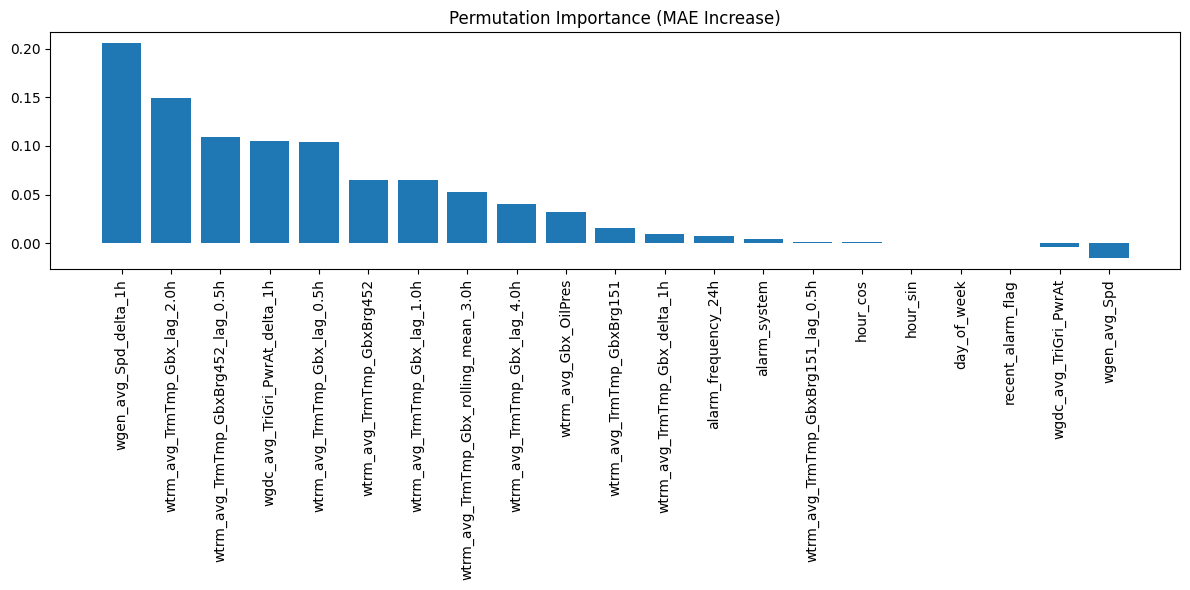

In [56]:
import matplotlib.pyplot as plt
import numpy as np

common_features = np.array(common_features)
importances = np.array(importances)

# Safe slicing
min_len = min(len(importances), len(common_features))
sorted_idx = np.argsort(importances[:min_len])[::-1]

plt.figure(figsize=(12, 6))
plt.bar(range(min_len), importances[sorted_idx])
plt.xticks(range(min_len), common_features[sorted_idx], rotation=90)
plt.title("Permutation Importance (MAE Increase)")
plt.tight_layout()
plt.show()


In [43]:
model.save('improved_model.h5')


In [58]:
import joblib
joblib.dump(feature_scaler, 'feature_scaler.pkl')
joblib.dump(target_scaler, 'target_scaler.pkl')


['target_scaler.pkl']

In [59]:
# import json
# with open('common_features.json', 'w') as f:
#     json.dump(common_features, f)
